In [ ]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Predicting Alzheimer vs Non-Alzheimer abstract/summary of published research papers with BERT on TF Hub

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [ ]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 3.2MB/s 


In [ ]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

Alternatively, if you're a GCP user, you can store output in a GCP bucket. To do that, set a directory name in OUTPUT_DIR and the name of the GCP bucket in the BUCKET field.

Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

In [ ]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'Alz_Model'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'Temp' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: Alz_Model *****


#Data

In [ ]:
from tensorflow import keras
import os
import re

In [ ]:
#train, test = download_and_load_datasets()

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
files.upload()

Saving Alz_data_cleaned_summary.txt to Alz_data_cleaned_summary.txt
Saving arxivData_summary.txt to arxivData_summary.txt


In [ ]:
#arxivData_summary.txt
pos_f = open("Alz_data_cleaned_summary.txt", 'r')
# Get list of all lines in file
pos_listOfLines = pos_f.readlines()


# Calling DataFrame constructor on list 
pos_df = pd.DataFrame(pos_listOfLines, columns =['abstract']) 
pos_df["label"] = 1

train_pos=pos_df.sample(frac=0.8,random_state=200) #random state is a seed value
test_pos=pos_df.drop(train_pos.index)
print(pos_df.shape)
print(train_pos.shape)
print(test_pos.shape)

(16161, 2)
(12929, 2)
(3232, 2)


In [ ]:
#arxivData_summary.txt
neg_f = open("arxivData_summary.txt", 'r')
# Get list of all lines in file
neg_listOfLines = neg_f.readlines()


neg_df = pd.DataFrame(neg_listOfLines, columns =['abstract']).sample(20000)
neg_df["label"] = 0
train_neg=neg_df.sample(frac=0.8,random_state=200) #random state is a seed value
test_neg=neg_df.drop(train_neg.index)
print(neg_df.shape)
print(train_neg.shape)
print(test_neg.shape)

(20000, 2)
(16000, 2)
(4000, 2)


In [ ]:
train = pd.concat([train_pos, train_neg]).sample(frac=1).reset_index(drop=True)
test = pd.concat([test_pos, test_neg]).sample(frac=1).reset_index(drop=True)
print(train.shape)
print(test.shape)

(28929, 2)
(7232, 2)


To keep training fast, we'll take a sample of 5000 train and test examples, respectively.

In [ ]:
train.columns

Index(['abstract', 'label'], dtype='object')

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [ ]:
DATA_COLUMN = 'abstract'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [ ]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [ ]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 28929


INFO:tensorflow:Writing example 0 of 28929


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we present metric ##s for measuring state similarity in marko ##v decision processes ( md ##ps ) with infinitely many states , including md ##ps with continuous state spaces . such metric ##s provide a stable quantitative analogue of the notion of bis ##im ##ulation for md ##ps , and are suitable for use in md ##p approximation . we show that the optimal value function associated with a discount ##ed infinite horizon planning task varies continuously with respect to our metric distances . [SEP]


INFO:tensorflow:tokens: [CLS] we present metric ##s for measuring state similarity in marko ##v decision processes ( md ##ps ) with infinitely many states , including md ##ps with continuous state spaces . such metric ##s provide a stable quantitative analogue of the notion of bis ##im ##ulation for md ##ps , and are suitable for use in md ##p approximation . we show that the optimal value function associated with a discount ##ed infinite horizon planning task varies continuously with respect to our metric distances . [SEP]


INFO:tensorflow:input_ids: 101 2057 2556 12046 2015 2005 9854 2110 14402 1999 28003 2615 3247 6194 1006 9108 4523 1007 2007 25773 2116 2163 1010 2164 9108 4523 2007 7142 2110 7258 1012 2107 12046 2015 3073 1037 6540 20155 21800 1997 1996 9366 1997 20377 5714 9513 2005 9108 4523 1010 1998 2024 7218 2005 2224 1999 9108 2361 20167 1012 2057 2265 2008 1996 15502 3643 3853 3378 2007 1037 19575 2098 10709 9154 4041 4708 9783 10843 2007 4847 2000 2256 12046 12103 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2057 2556 12046 2015 2005 9854 2110 14402 1999 28003 2615 3247 6194 1006 9108 4523 1007 2007 25773 2116 2163 1010 2164 9108 4523 2007 7142 2110 7258 1012 2107 12046 2015 3073 1037 6540 20155 21800 1997 1996 9366 1997 20377 5714 9513 2005 9108 4523 1010 1998 2024 7218 2005 2224 1999 9108 2361 20167 1012 2057 2265 2008 1996 15502 3643 3853 3378 2007 1037 19575 2098 10709 9154 4041 4708 9783 10843 2007 4847 2000 2256 12046 12103 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this paper presents a method of learning qu ##ali ##tative ##ly interpret ##able models in object detection using popular two - stage region - based con ##vn ##et detection systems ( i . e . , r - cnn ) . r - cnn consists of a region proposal network and a roi ( region - of - interest ) prediction network . by interpret ##able models , we focus on weakly - supervised extract ##ive rational ##e generation , that is learning to un ##fold late ##nt disc ##rim ##ina ##tive part configurations of object instances automatically and simultaneously in detection without using any supervision for part configurations . we utilize a top - down hierarchical and composition ##al grammar model embedded in a directed [SEP]


INFO:tensorflow:tokens: [CLS] this paper presents a method of learning qu ##ali ##tative ##ly interpret ##able models in object detection using popular two - stage region - based con ##vn ##et detection systems ( i . e . , r - cnn ) . r - cnn consists of a region proposal network and a roi ( region - of - interest ) prediction network . by interpret ##able models , we focus on weakly - supervised extract ##ive rational ##e generation , that is learning to un ##fold late ##nt disc ##rim ##ina ##tive part configurations of object instances automatically and simultaneously in detection without using any supervision for part configurations . we utilize a top - down hierarchical and composition ##al grammar model embedded in a directed [SEP]


INFO:tensorflow:input_ids: 101 2023 3259 7534 1037 4118 1997 4083 24209 11475 27453 2135 17841 3085 4275 1999 4874 10788 2478 2759 2048 1011 2754 2555 1011 2241 9530 16022 3388 10788 3001 1006 1045 1012 1041 1012 1010 1054 1011 13229 1007 1012 1054 1011 13229 3774 1997 1037 2555 6378 2897 1998 1037 25223 1006 2555 1011 1997 1011 3037 1007 17547 2897 1012 2011 17841 3085 4275 1010 2057 3579 2006 17541 1011 13588 14817 3512 11581 2063 4245 1010 2008 2003 4083 2000 4895 10371 2397 3372 5860 20026 3981 6024 2112 22354 1997 4874 12107 8073 1998 7453 1999 10788 2302 2478 2151 10429 2005 2112 22354 1012 2057 16462 1037 2327 1011 2091 25835 1998 5512 2389 8035 2944 11157 1999 1037 2856 102


INFO:tensorflow:input_ids: 101 2023 3259 7534 1037 4118 1997 4083 24209 11475 27453 2135 17841 3085 4275 1999 4874 10788 2478 2759 2048 1011 2754 2555 1011 2241 9530 16022 3388 10788 3001 1006 1045 1012 1041 1012 1010 1054 1011 13229 1007 1012 1054 1011 13229 3774 1997 1037 2555 6378 2897 1998 1037 25223 1006 2555 1011 1997 1011 3037 1007 17547 2897 1012 2011 17841 3085 4275 1010 2057 3579 2006 17541 1011 13588 14817 3512 11581 2063 4245 1010 2008 2003 4083 2000 4895 10371 2397 3372 5860 20026 3981 6024 2112 22354 1997 4874 12107 8073 1998 7453 1999 10788 2302 2478 2151 10429 2005 2112 22354 1012 2057 16462 1037 2327 1011 2091 25835 1998 5512 2389 8035 2944 11157 1999 1037 2856 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] introduction : tre ##m ##2 is involved in the regulation of inflammatory response and ph ##ago ##cy ##tosis . a soluble fragment ( st ##rem ##2 ) is often found abnormal ##ly increased in ce ##re ##bro ##sp ##inal fluid ( cs ##f ) in alzheimer ##s disease ( ad ) . methods : one hundred fourteen participants ( 45 control , 19 pre ##cl ##ini ##cal , 27 mild cognitive impairment [ mc ##i ] , and 23 ad ) underwent cs ##f st ##rem ##2 determination and magnetic resonance imaging ( mri ) . we studied the association between cs ##f st ##rem ##2 , gray matter volume , and water motion di ##ff ##us ##ivity and an ##iso ##tro ##py across groups . [SEP]


INFO:tensorflow:tokens: [CLS] introduction : tre ##m ##2 is involved in the regulation of inflammatory response and ph ##ago ##cy ##tosis . a soluble fragment ( st ##rem ##2 ) is often found abnormal ##ly increased in ce ##re ##bro ##sp ##inal fluid ( cs ##f ) in alzheimer ##s disease ( ad ) . methods : one hundred fourteen participants ( 45 control , 19 pre ##cl ##ini ##cal , 27 mild cognitive impairment [ mc ##i ] , and 23 ad ) underwent cs ##f st ##rem ##2 determination and magnetic resonance imaging ( mri ) . we studied the association between cs ##f st ##rem ##2 , gray matter volume , and water motion di ##ff ##us ##ivity and an ##iso ##tro ##py across groups . [SEP]


INFO:tensorflow:input_ids: 101 4955 1024 29461 2213 2475 2003 2920 1999 1996 7816 1997 20187 3433 1998 6887 23692 5666 25950 1012 1037 24345 15778 1006 2358 28578 2475 1007 2003 2411 2179 19470 2135 3445 1999 8292 2890 12618 13102 13290 8331 1006 20116 2546 1007 1999 21901 2015 4295 1006 4748 1007 1012 4725 1024 2028 3634 7426 6818 1006 3429 2491 1010 2539 3653 20464 5498 9289 1010 2676 10256 10699 25172 1031 11338 2072 1033 1010 1998 2603 4748 1007 9601 20116 2546 2358 28578 2475 9128 1998 8060 17011 12126 1006 27011 1007 1012 2057 3273 1996 2523 2090 20116 2546 2358 28578 2475 1010 3897 3043 3872 1010 1998 2300 4367 4487 4246 2271 7730 1998 2019 19565 13181 7685 2408 2967 1012 102


INFO:tensorflow:input_ids: 101 4955 1024 29461 2213 2475 2003 2920 1999 1996 7816 1997 20187 3433 1998 6887 23692 5666 25950 1012 1037 24345 15778 1006 2358 28578 2475 1007 2003 2411 2179 19470 2135 3445 1999 8292 2890 12618 13102 13290 8331 1006 20116 2546 1007 1999 21901 2015 4295 1006 4748 1007 1012 4725 1024 2028 3634 7426 6818 1006 3429 2491 1010 2539 3653 20464 5498 9289 1010 2676 10256 10699 25172 1031 11338 2072 1033 1010 1998 2603 4748 1007 9601 20116 2546 2358 28578 2475 9128 1998 8060 17011 12126 1006 27011 1007 1012 2057 3273 1996 2523 2090 20116 2546 2358 28578 2475 1010 3897 3043 3872 1010 1998 2300 4367 4487 4246 2271 7730 1998 2019 19565 13181 7685 2408 2967 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] most existing approaches to hash ##ing apply a single form of hash function , and an optimization process which is typically deeply coupled to this specific form . this tight coupling restrict ##s the flexibility of the method to respond to the data , and can result in complex optimization problems that are difficult to solve . here we propose a flexible yet simple framework that is able to accommodate different types of loss functions and hash functions . this framework allows a number of existing approaches to hash ##ing to be placed in context , and sim ##pl ##ifies the development of new problem - specific hash ##ing methods . our framework deco ##mp ##oses hash ##ing learning problem into two steps : hash bit [SEP]


INFO:tensorflow:tokens: [CLS] most existing approaches to hash ##ing apply a single form of hash function , and an optimization process which is typically deeply coupled to this specific form . this tight coupling restrict ##s the flexibility of the method to respond to the data , and can result in complex optimization problems that are difficult to solve . here we propose a flexible yet simple framework that is able to accommodate different types of loss functions and hash functions . this framework allows a number of existing approaches to hash ##ing to be placed in context , and sim ##pl ##ifies the development of new problem - specific hash ##ing methods . our framework deco ##mp ##oses hash ##ing learning problem into two steps : hash bit [SEP]


INFO:tensorflow:input_ids: 101 2087 4493 8107 2000 23325 2075 6611 1037 2309 2433 1997 23325 3853 1010 1998 2019 20600 2832 2029 2003 4050 6171 11211 2000 2023 3563 2433 1012 2023 4389 19780 21573 2015 1996 16991 1997 1996 4118 2000 6869 2000 1996 2951 1010 1998 2064 2765 1999 3375 20600 3471 2008 2024 3697 2000 9611 1012 2182 2057 16599 1037 12379 2664 3722 7705 2008 2003 2583 2000 8752 2367 4127 1997 3279 4972 1998 23325 4972 1012 2023 7705 4473 1037 2193 1997 4493 8107 2000 23325 2075 2000 2022 2872 1999 6123 1010 1998 21934 24759 14144 1996 2458 1997 2047 3291 1011 3563 23325 2075 4725 1012 2256 7705 21933 8737 27465 23325 2075 4083 3291 2046 2048 4084 1024 23325 2978 102


INFO:tensorflow:input_ids: 101 2087 4493 8107 2000 23325 2075 6611 1037 2309 2433 1997 23325 3853 1010 1998 2019 20600 2832 2029 2003 4050 6171 11211 2000 2023 3563 2433 1012 2023 4389 19780 21573 2015 1996 16991 1997 1996 4118 2000 6869 2000 1996 2951 1010 1998 2064 2765 1999 3375 20600 3471 2008 2024 3697 2000 9611 1012 2182 2057 16599 1037 12379 2664 3722 7705 2008 2003 2583 2000 8752 2367 4127 1997 3279 4972 1998 23325 4972 1012 2023 7705 4473 1037 2193 1997 4493 8107 2000 23325 2075 2000 2022 2872 1999 6123 1010 1998 21934 24759 14144 1996 2458 1997 2047 3291 1011 3563 23325 2075 4725 1012 2256 7705 21933 8737 27465 23325 2075 4083 3291 2046 2048 4084 1024 23325 2978 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] deep learning applies hierarchical layers of hidden variables to construct nonlinear high dimensional predict ##ors . our goal is to develop and train deep learning architecture ##s for spat ##io - temporal modeling . training a deep architecture is achieved by st ##och ##astic gradient descent ( sg ##d ) and drop - out ( do ) for parameter regular ##ization with a goal of mini ##mi ##zing out - of - sample predict ##ive mean squared error . to illustrate our methodology , we predict the sharp disco ##nti ##nu ##ities in traffic flow data , and secondly , we develop a classification rule to predict short - term futures market prices as a function of the order book depth . finally , we conclude [SEP]


INFO:tensorflow:tokens: [CLS] deep learning applies hierarchical layers of hidden variables to construct nonlinear high dimensional predict ##ors . our goal is to develop and train deep learning architecture ##s for spat ##io - temporal modeling . training a deep architecture is achieved by st ##och ##astic gradient descent ( sg ##d ) and drop - out ( do ) for parameter regular ##ization with a goal of mini ##mi ##zing out - of - sample predict ##ive mean squared error . to illustrate our methodology , we predict the sharp disco ##nti ##nu ##ities in traffic flow data , and secondly , we develop a classification rule to predict short - term futures market prices as a function of the order book depth . finally , we conclude [SEP]


INFO:tensorflow:input_ids: 101 2784 4083 12033 25835 9014 1997 5023 10857 2000 9570 27400 2152 8789 16014 5668 1012 2256 3125 2003 2000 4503 1998 3345 2784 4083 4294 2015 2005 14690 3695 1011 15850 11643 1012 2731 1037 2784 4294 2003 4719 2011 2358 11663 20875 17978 6934 1006 22214 2094 1007 1998 4530 1011 2041 1006 2079 1007 2005 16381 3180 3989 2007 1037 3125 1997 7163 4328 6774 2041 1011 1997 1011 7099 16014 3512 2812 19942 7561 1012 2000 19141 2256 16134 1010 2057 16014 1996 4629 12532 16778 11231 6447 1999 4026 4834 2951 1010 1998 16378 1010 2057 4503 1037 5579 3627 2000 16014 2460 1011 2744 17795 3006 7597 2004 1037 3853 1997 1996 2344 2338 5995 1012 2633 1010 2057 16519 102


INFO:tensorflow:input_ids: 101 2784 4083 12033 25835 9014 1997 5023 10857 2000 9570 27400 2152 8789 16014 5668 1012 2256 3125 2003 2000 4503 1998 3345 2784 4083 4294 2015 2005 14690 3695 1011 15850 11643 1012 2731 1037 2784 4294 2003 4719 2011 2358 11663 20875 17978 6934 1006 22214 2094 1007 1998 4530 1011 2041 1006 2079 1007 2005 16381 3180 3989 2007 1037 3125 1997 7163 4328 6774 2041 1011 1997 1011 7099 16014 3512 2812 19942 7561 1012 2000 19141 2256 16134 1010 2057 16014 1996 4629 12532 16778 11231 6447 1999 4026 4834 2951 1010 1998 16378 1010 2057 4503 1037 5579 3627 2000 16014 2460 1011 2744 17795 3006 7597 2004 1037 3853 1997 1996 2344 2338 5995 1012 2633 1010 2057 16519 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 28929


INFO:tensorflow:Writing example 10000 of 28929


INFO:tensorflow:Writing example 20000 of 28929


INFO:tensorflow:Writing example 20000 of 28929


INFO:tensorflow:Writing example 0 of 7232


INFO:tensorflow:Writing example 0 of 7232


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we propose a new algorithm for training genera ##tive ad ##vers ##aria ##l networks that jointly learns late ##nt codes for both identities ( e . g . individual humans ) and observations ( e . g . specific photographs ) . by fixing the identity portion of the late ##nt codes , we can generate diverse images of the same subject , and by fixing the observation portion , we can traverse the manifold of subjects while maintaining contingent aspects such as lighting and pose . our algorithm features a pair ##wise training scheme in which each sample from the generator consists of two images with a common identity code . corresponding samples from the real data ##set consist of two distinct photographs of the [SEP]


INFO:tensorflow:tokens: [CLS] we propose a new algorithm for training genera ##tive ad ##vers ##aria ##l networks that jointly learns late ##nt codes for both identities ( e . g . individual humans ) and observations ( e . g . specific photographs ) . by fixing the identity portion of the late ##nt codes , we can generate diverse images of the same subject , and by fixing the observation portion , we can traverse the manifold of subjects while maintaining contingent aspects such as lighting and pose . our algorithm features a pair ##wise training scheme in which each sample from the generator consists of two images with a common identity code . corresponding samples from the real data ##set consist of two distinct photographs of the [SEP]


INFO:tensorflow:input_ids: 101 2057 16599 1037 2047 9896 2005 2731 11416 6024 4748 14028 10980 2140 6125 2008 10776 10229 2397 3372 9537 2005 2119 15702 1006 1041 1012 1043 1012 3265 4286 1007 1998 9420 1006 1041 1012 1043 1012 3563 7008 1007 1012 2011 15887 1996 4767 4664 1997 1996 2397 3372 9537 1010 2057 2064 9699 7578 4871 1997 1996 2168 3395 1010 1998 2011 15887 1996 8089 4664 1010 2057 2064 20811 1996 19726 1997 5739 2096 8498 15445 5919 2107 2004 7497 1998 13382 1012 2256 9896 2838 1037 3940 14244 2731 5679 1999 2029 2169 7099 2013 1996 13103 3774 1997 2048 4871 2007 1037 2691 4767 3642 1012 7978 8168 2013 1996 2613 2951 13462 8676 1997 2048 5664 7008 1997 1996 102


INFO:tensorflow:input_ids: 101 2057 16599 1037 2047 9896 2005 2731 11416 6024 4748 14028 10980 2140 6125 2008 10776 10229 2397 3372 9537 2005 2119 15702 1006 1041 1012 1043 1012 3265 4286 1007 1998 9420 1006 1041 1012 1043 1012 3563 7008 1007 1012 2011 15887 1996 4767 4664 1997 1996 2397 3372 9537 1010 2057 2064 9699 7578 4871 1997 1996 2168 3395 1010 1998 2011 15887 1996 8089 4664 1010 2057 2064 20811 1996 19726 1997 5739 2096 8498 15445 5919 2107 2004 7497 1998 13382 1012 2256 9896 2838 1037 3940 14244 2731 5679 1999 2029 2169 7099 2013 1996 13103 3774 1997 2048 4871 2007 1037 2691 4767 3642 1012 7978 8168 2013 1996 2613 2951 13462 8676 1997 2048 5664 7008 1997 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] recent work on en ##code ##r - deco ##der models for sequence - to - sequence mapping has shown that integrating both temporal and spatial attention mechanisms into neural networks increases the performance of the system substantially . in this work , we report on the application of an attention ##al signal not on temporal and spatial regions of the input , but instead as a method of switching among inputs themselves . we evaluate the particular role of attention ##al switching in the presence of dynamic noise in the sensors , and demonstrate how the attention ##al signal responds dynamic ##ally to changing noise levels in the environment to achieve increased performance on both audio and visual tasks in three commonly - used data ##set [SEP]


INFO:tensorflow:tokens: [CLS] recent work on en ##code ##r - deco ##der models for sequence - to - sequence mapping has shown that integrating both temporal and spatial attention mechanisms into neural networks increases the performance of the system substantially . in this work , we report on the application of an attention ##al signal not on temporal and spatial regions of the input , but instead as a method of switching among inputs themselves . we evaluate the particular role of attention ##al switching in the presence of dynamic noise in the sensors , and demonstrate how the attention ##al signal responds dynamic ##ally to changing noise levels in the environment to achieve increased performance on both audio and visual tasks in three commonly - used data ##set [SEP]


INFO:tensorflow:input_ids: 101 3522 2147 2006 4372 16044 2099 1011 21933 4063 4275 2005 5537 1011 2000 1011 5537 12375 2038 3491 2008 22380 2119 15850 1998 13589 3086 10595 2046 15756 6125 7457 1996 2836 1997 1996 2291 12381 1012 1999 2023 2147 1010 2057 3189 2006 1996 4646 1997 2019 3086 2389 4742 2025 2006 15850 1998 13589 4655 1997 1996 7953 1010 2021 2612 2004 1037 4118 1997 11991 2426 20407 3209 1012 2057 16157 1996 3327 2535 1997 3086 2389 11991 1999 1996 3739 1997 8790 5005 1999 1996 13907 1010 1998 10580 2129 1996 3086 2389 4742 16412 8790 3973 2000 5278 5005 3798 1999 1996 4044 2000 6162 3445 2836 2006 2119 5746 1998 5107 8518 1999 2093 4141 1011 2109 2951 13462 102


INFO:tensorflow:input_ids: 101 3522 2147 2006 4372 16044 2099 1011 21933 4063 4275 2005 5537 1011 2000 1011 5537 12375 2038 3491 2008 22380 2119 15850 1998 13589 3086 10595 2046 15756 6125 7457 1996 2836 1997 1996 2291 12381 1012 1999 2023 2147 1010 2057 3189 2006 1996 4646 1997 2019 3086 2389 4742 2025 2006 15850 1998 13589 4655 1997 1996 7953 1010 2021 2612 2004 1037 4118 1997 11991 2426 20407 3209 1012 2057 16157 1996 3327 2535 1997 3086 2389 11991 1999 1996 3739 1997 8790 5005 1999 1996 13907 1010 1998 10580 2129 1996 3086 2389 4742 16412 8790 3973 2000 5278 5005 3798 1999 1996 4044 2000 6162 3445 2836 2006 2119 5746 1998 5107 8518 1999 2093 4141 1011 2109 2951 13462 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] introduction : functional and cognitive features of subjective cognitive decline ( sc ##d ) were identified in a longitudinal database from the national alzheimer ##s coordinating center . methods : cognitive ##ly normal older adults with ( sc ##d + ) and without ( sc ##d - ) self - reported memory complaints ( n = 39 ##15 ) were compared on ( 1 ) baseline functional assessment question ##naire ratings , ( 2 ) baseline scores and longitudinal rate of change estimates from nine ne ##uro ##psy ##cho ##logical tests , and ( 3 ) final clinical dia ##gno ##ses . results : sc ##d + had higher baseline ratings of functional impairment , reduced ep ##iso ##dic memory practice effects and poorer performance on [SEP]


INFO:tensorflow:tokens: [CLS] introduction : functional and cognitive features of subjective cognitive decline ( sc ##d ) were identified in a longitudinal database from the national alzheimer ##s coordinating center . methods : cognitive ##ly normal older adults with ( sc ##d + ) and without ( sc ##d - ) self - reported memory complaints ( n = 39 ##15 ) were compared on ( 1 ) baseline functional assessment question ##naire ratings , ( 2 ) baseline scores and longitudinal rate of change estimates from nine ne ##uro ##psy ##cho ##logical tests , and ( 3 ) final clinical dia ##gno ##ses . results : sc ##d + had higher baseline ratings of functional impairment , reduced ep ##iso ##dic memory practice effects and poorer performance on [SEP]


INFO:tensorflow:input_ids: 101 4955 1024 8360 1998 10699 2838 1997 20714 10699 6689 1006 8040 2094 1007 2020 4453 1999 1037 20134 7809 2013 1996 2120 21901 2015 19795 2415 1012 4725 1024 10699 2135 3671 3080 6001 2007 1006 8040 2094 1009 1007 1998 2302 1006 8040 2094 1011 1007 2969 1011 2988 3638 10821 1006 1050 1027 4464 16068 1007 2020 4102 2006 1006 1015 1007 26163 8360 7667 3160 20589 8599 1010 1006 1016 1007 26163 7644 1998 20134 3446 1997 2689 10035 2013 3157 11265 10976 18075 9905 9966 5852 1010 1998 1006 1017 1007 2345 6612 22939 26745 8583 1012 3463 1024 8040 2094 1009 2018 3020 26163 8599 1997 8360 25172 1010 4359 4958 19565 14808 3638 3218 3896 1998 27196 2836 2006 102


INFO:tensorflow:input_ids: 101 4955 1024 8360 1998 10699 2838 1997 20714 10699 6689 1006 8040 2094 1007 2020 4453 1999 1037 20134 7809 2013 1996 2120 21901 2015 19795 2415 1012 4725 1024 10699 2135 3671 3080 6001 2007 1006 8040 2094 1009 1007 1998 2302 1006 8040 2094 1011 1007 2969 1011 2988 3638 10821 1006 1050 1027 4464 16068 1007 2020 4102 2006 1006 1015 1007 26163 8360 7667 3160 20589 8599 1010 1006 1016 1007 26163 7644 1998 20134 3446 1997 2689 10035 2013 3157 11265 10976 18075 9905 9966 5852 1010 1998 1006 1017 1007 2345 6612 22939 26745 8583 1012 3463 1024 8040 2094 1009 2018 3020 26163 8599 1997 8360 25172 1010 4359 4958 19565 14808 3638 3218 3896 1998 27196 2836 2006 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] background : small scale shared housing arrangements ( sha ##s ) is a dei ##nst ##it ##ution ##ali ##zed model of care designed to resemble a typical home of < 10 people and are increasingly available for persons with ne ##uro ##co ##gni ##tive disorders of the alzheimer ##s and related types ( nc ##d ) . however , there is little aggregate evidence of their effect on persons with nc ##d thus , a literature review was performed . methods : database searches were conducted across ci ##nah ##l complete , ot ##see ##ker , pub ##med , o ##vid , academic one file , pro ##quest nursing and allied health , the world wide web and google scholar using the several key words that [SEP]


INFO:tensorflow:tokens: [CLS] background : small scale shared housing arrangements ( sha ##s ) is a dei ##nst ##it ##ution ##ali ##zed model of care designed to resemble a typical home of < 10 people and are increasingly available for persons with ne ##uro ##co ##gni ##tive disorders of the alzheimer ##s and related types ( nc ##d ) . however , there is little aggregate evidence of their effect on persons with nc ##d thus , a literature review was performed . methods : database searches were conducted across ci ##nah ##l complete , ot ##see ##ker , pub ##med , o ##vid , academic one file , pro ##quest nursing and allied health , the world wide web and google scholar using the several key words that [SEP]


INFO:tensorflow:input_ids: 101 4281 1024 2235 4094 4207 3847 7565 1006 21146 2015 1007 2003 1037 14866 23808 4183 13700 11475 5422 2944 1997 2729 2881 2000 13014 1037 5171 2188 1997 1026 2184 2111 1998 2024 6233 2800 2005 5381 2007 11265 10976 3597 29076 6024 10840 1997 1996 21901 2015 1998 3141 4127 1006 13316 2094 1007 1012 2174 1010 2045 2003 2210 9572 3350 1997 2037 3466 2006 5381 2007 13316 2094 2947 1010 1037 3906 3319 2001 2864 1012 4725 1024 7809 17193 2020 4146 2408 25022 15272 2140 3143 1010 27178 19763 5484 1010 9047 7583 1010 1051 17258 1010 3834 2028 5371 1010 4013 15500 8329 1998 6035 2740 1010 1996 2088 2898 4773 1998 8224 6288 2478 1996 2195 3145 2616 2008 102


INFO:tensorflow:input_ids: 101 4281 1024 2235 4094 4207 3847 7565 1006 21146 2015 1007 2003 1037 14866 23808 4183 13700 11475 5422 2944 1997 2729 2881 2000 13014 1037 5171 2188 1997 1026 2184 2111 1998 2024 6233 2800 2005 5381 2007 11265 10976 3597 29076 6024 10840 1997 1996 21901 2015 1998 3141 4127 1006 13316 2094 1007 1012 2174 1010 2045 2003 2210 9572 3350 1997 2037 3466 2006 5381 2007 13316 2094 2947 1010 1037 3906 3319 2001 2864 1012 4725 1024 7809 17193 2020 4146 2408 25022 15272 2140 3143 1010 27178 19763 5484 1010 9047 7583 1010 1051 17258 1010 3834 2028 5371 1010 4013 15500 8329 1998 6035 2740 1010 1996 2088 2898 4773 1998 8224 6288 2478 1996 2195 3145 2616 2008 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] increasing evidence suggests that early diagnosis and management of dementia - related symptoms may improve the quality of life for patients and their families . however , individuals may wait from 1 - 3 years from the onset of symptoms before receiving a diagnosis . the objective of this qu ##ali ##tative study was to explore the perceptions and experiences of problem recognition , and the process of obtaining a diagnosis among individuals with early - stage dementia and their primary care ##rs . from 2006 - 2009 , six anglo - canadians with dementia and seven of their care ##rs were recruited from the alzheimer ##s society of calgary to participate in semi - structured interviews . using an ind ##uc ##tive , thematic approach [SEP]


INFO:tensorflow:tokens: [CLS] increasing evidence suggests that early diagnosis and management of dementia - related symptoms may improve the quality of life for patients and their families . however , individuals may wait from 1 - 3 years from the onset of symptoms before receiving a diagnosis . the objective of this qu ##ali ##tative study was to explore the perceptions and experiences of problem recognition , and the process of obtaining a diagnosis among individuals with early - stage dementia and their primary care ##rs . from 2006 - 2009 , six anglo - canadians with dementia and seven of their care ##rs were recruited from the alzheimer ##s society of calgary to participate in semi - structured interviews . using an ind ##uc ##tive , thematic approach [SEP]


INFO:tensorflow:input_ids: 101 4852 3350 6083 2008 2220 11616 1998 2968 1997 28767 1011 3141 8030 2089 5335 1996 3737 1997 2166 2005 5022 1998 2037 2945 1012 2174 1010 3633 2089 3524 2013 1015 1011 1017 2086 2013 1996 14447 1997 8030 2077 4909 1037 11616 1012 1996 7863 1997 2023 24209 11475 27453 2817 2001 2000 8849 1996 23271 1998 6322 1997 3291 5038 1010 1998 1996 2832 1997 11381 1037 11616 2426 3633 2007 2220 1011 2754 28767 1998 2037 3078 2729 2869 1012 2013 2294 1011 2268 1010 2416 7819 1011 16485 2007 28767 1998 2698 1997 2037 2729 2869 2020 8733 2013 1996 21901 2015 2554 1997 10112 2000 5589 1999 4100 1011 14336 7636 1012 2478 2019 27427 14194 6024 1010 23539 3921 102


INFO:tensorflow:input_ids: 101 4852 3350 6083 2008 2220 11616 1998 2968 1997 28767 1011 3141 8030 2089 5335 1996 3737 1997 2166 2005 5022 1998 2037 2945 1012 2174 1010 3633 2089 3524 2013 1015 1011 1017 2086 2013 1996 14447 1997 8030 2077 4909 1037 11616 1012 1996 7863 1997 2023 24209 11475 27453 2817 2001 2000 8849 1996 23271 1998 6322 1997 3291 5038 1010 1998 1996 2832 1997 11381 1037 11616 2426 3633 2007 2220 1011 2754 28767 1998 2037 3078 2729 2869 1012 2013 2294 1011 2268 1010 2416 7819 1011 16485 2007 28767 1998 2698 1997 2037 2729 2869 2020 8733 2013 1996 21901 2015 2554 1997 10112 2000 5589 1999 4100 1011 14336 7636 1012 2478 2019 27427 14194 6024 1010 23539 3921 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [ ]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'Alz_Model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b9cd5b278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'Alz_Model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b9cd5b278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into Alz_Model/model.ckpt.


INFO:tensorflow:loss = 0.7087189, step = 0


INFO:tensorflow:loss = 0.7087189, step = 0


INFO:tensorflow:global_step/sec: 0.538988


INFO:tensorflow:global_step/sec: 0.538988


INFO:tensorflow:loss = 0.009250313, step = 100 (185.535 sec)


INFO:tensorflow:loss = 0.009250313, step = 100 (185.535 sec)


INFO:tensorflow:global_step/sec: 0.601544


INFO:tensorflow:global_step/sec: 0.601544


INFO:tensorflow:loss = 0.12348202, step = 200 (166.244 sec)


INFO:tensorflow:loss = 0.12348202, step = 200 (166.244 sec)


INFO:tensorflow:global_step/sec: 0.601409


INFO:tensorflow:global_step/sec: 0.601409


INFO:tensorflow:loss = 0.016573114, step = 300 (166.271 sec)


INFO:tensorflow:loss = 0.016573114, step = 300 (166.271 sec)


INFO:tensorflow:global_step/sec: 0.60194


INFO:tensorflow:global_step/sec: 0.60194


INFO:tensorflow:loss = 0.00084946747, step = 400 (166.135 sec)


INFO:tensorflow:loss = 0.00084946747, step = 400 (166.135 sec)


INFO:tensorflow:Saving checkpoints for 500 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into Alz_Model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.579343


INFO:tensorflow:global_step/sec: 0.579343


INFO:tensorflow:loss = 0.1306174, step = 500 (172.608 sec)


INFO:tensorflow:loss = 0.1306174, step = 500 (172.608 sec)


INFO:tensorflow:global_step/sec: 0.601719


INFO:tensorflow:global_step/sec: 0.601719


INFO:tensorflow:loss = 0.07177218, step = 600 (166.191 sec)


INFO:tensorflow:loss = 0.07177218, step = 600 (166.191 sec)


INFO:tensorflow:global_step/sec: 0.601473


INFO:tensorflow:global_step/sec: 0.601473


INFO:tensorflow:loss = 0.0034324762, step = 700 (166.254 sec)


INFO:tensorflow:loss = 0.0034324762, step = 700 (166.254 sec)


INFO:tensorflow:global_step/sec: 0.601998


INFO:tensorflow:global_step/sec: 0.601998


INFO:tensorflow:loss = 0.0016858852, step = 800 (166.117 sec)


INFO:tensorflow:loss = 0.0016858852, step = 800 (166.117 sec)


INFO:tensorflow:global_step/sec: 0.601954


INFO:tensorflow:global_step/sec: 0.601954


INFO:tensorflow:loss = 0.0031871914, step = 900 (166.122 sec)


INFO:tensorflow:loss = 0.0031871914, step = 900 (166.122 sec)


INFO:tensorflow:Saving checkpoints for 1000 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into Alz_Model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.57929


INFO:tensorflow:global_step/sec: 0.57929


INFO:tensorflow:loss = 0.00057717133, step = 1000 (172.625 sec)


INFO:tensorflow:loss = 0.00057717133, step = 1000 (172.625 sec)


INFO:tensorflow:global_step/sec: 0.602453


INFO:tensorflow:global_step/sec: 0.602453


INFO:tensorflow:loss = 0.00044334913, step = 1100 (165.994 sec)


INFO:tensorflow:loss = 0.00044334913, step = 1100 (165.994 sec)


INFO:tensorflow:global_step/sec: 0.601945


INFO:tensorflow:global_step/sec: 0.601945


INFO:tensorflow:loss = 0.093342766, step = 1200 (166.128 sec)


INFO:tensorflow:loss = 0.093342766, step = 1200 (166.128 sec)


INFO:tensorflow:global_step/sec: 0.601652


INFO:tensorflow:global_step/sec: 0.601652


INFO:tensorflow:loss = 0.0011714932, step = 1300 (166.204 sec)


INFO:tensorflow:loss = 0.0011714932, step = 1300 (166.204 sec)


INFO:tensorflow:global_step/sec: 0.60171


INFO:tensorflow:global_step/sec: 0.60171


INFO:tensorflow:loss = 0.008173218, step = 1400 (166.193 sec)


INFO:tensorflow:loss = 0.008173218, step = 1400 (166.193 sec)


INFO:tensorflow:Saving checkpoints for 1500 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into Alz_Model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.579228


INFO:tensorflow:global_step/sec: 0.579228


INFO:tensorflow:loss = 0.00064571435, step = 1500 (172.649 sec)


INFO:tensorflow:loss = 0.00064571435, step = 1500 (172.649 sec)


INFO:tensorflow:global_step/sec: 0.601198


INFO:tensorflow:global_step/sec: 0.601198


INFO:tensorflow:loss = 0.0005864804, step = 1600 (166.330 sec)


INFO:tensorflow:loss = 0.0005864804, step = 1600 (166.330 sec)


INFO:tensorflow:global_step/sec: 0.601656


INFO:tensorflow:global_step/sec: 0.601656


INFO:tensorflow:loss = 0.00020430764, step = 1700 (166.208 sec)


INFO:tensorflow:loss = 0.00020430764, step = 1700 (166.208 sec)


INFO:tensorflow:global_step/sec: 0.601573


INFO:tensorflow:global_step/sec: 0.601573


INFO:tensorflow:loss = 0.25628603, step = 1800 (166.236 sec)


INFO:tensorflow:loss = 0.25628603, step = 1800 (166.236 sec)


INFO:tensorflow:global_step/sec: 0.601381


INFO:tensorflow:global_step/sec: 0.601381


INFO:tensorflow:loss = 0.0003555774, step = 1900 (166.278 sec)


INFO:tensorflow:loss = 0.0003555774, step = 1900 (166.278 sec)


INFO:tensorflow:Saving checkpoints for 2000 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into Alz_Model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.578896


INFO:tensorflow:global_step/sec: 0.578896


INFO:tensorflow:loss = 0.00018393085, step = 2000 (172.742 sec)


INFO:tensorflow:loss = 0.00018393085, step = 2000 (172.742 sec)


INFO:tensorflow:global_step/sec: 0.601113


INFO:tensorflow:global_step/sec: 0.601113


INFO:tensorflow:loss = 0.0001819369, step = 2100 (166.358 sec)


INFO:tensorflow:loss = 0.0001819369, step = 2100 (166.358 sec)


INFO:tensorflow:global_step/sec: 0.601993


INFO:tensorflow:global_step/sec: 0.601993


INFO:tensorflow:loss = 0.000388198, step = 2200 (166.119 sec)


INFO:tensorflow:loss = 0.000388198, step = 2200 (166.119 sec)


INFO:tensorflow:global_step/sec: 0.601486


INFO:tensorflow:global_step/sec: 0.601486


INFO:tensorflow:loss = 0.00018523222, step = 2300 (166.253 sec)


INFO:tensorflow:loss = 0.00018523222, step = 2300 (166.253 sec)


INFO:tensorflow:global_step/sec: 0.601375


INFO:tensorflow:global_step/sec: 0.601375


INFO:tensorflow:loss = 0.02705337, step = 2400 (166.283 sec)


INFO:tensorflow:loss = 0.02705337, step = 2400 (166.283 sec)


INFO:tensorflow:Saving checkpoints for 2500 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into Alz_Model/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.578217


INFO:tensorflow:global_step/sec: 0.578217


INFO:tensorflow:loss = 0.0014860607, step = 2500 (172.945 sec)


INFO:tensorflow:loss = 0.0014860607, step = 2500 (172.945 sec)


INFO:tensorflow:global_step/sec: 0.601567


INFO:tensorflow:global_step/sec: 0.601567


INFO:tensorflow:loss = 0.00018663416, step = 2600 (166.233 sec)


INFO:tensorflow:loss = 0.00018663416, step = 2600 (166.233 sec)


INFO:tensorflow:global_step/sec: 0.601336


INFO:tensorflow:global_step/sec: 0.601336


INFO:tensorflow:loss = 0.00015764966, step = 2700 (166.299 sec)


INFO:tensorflow:loss = 0.00015764966, step = 2700 (166.299 sec)


INFO:tensorflow:Saving checkpoints for 2712 into Alz_Model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2712 into Alz_Model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.00027178612.


INFO:tensorflow:Loss for final step: 0.00027178612.


Training took time  1:17:15.547719


Now let's use our test data to see how well our model did:

In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-10-11T18:19:53Z


INFO:tensorflow:Starting evaluation at 2019-10-11T18:19:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from Alz_Model/model.ckpt-2712


INFO:tensorflow:Restoring parameters from Alz_Model/model.ckpt-2712


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: ignored

Now let's write code to make predictions on new sentences:

In [ ]:
def getPrediction(in_sentences):
  labels = ["Non_Alzheimer", "Alzheimer"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = [
  "Thyrotropin-releasing hormone (TRH), luteinizing hormone-releasing hormone (LH-RH), substance P immuno-reactivity and choline acetyltransferase activity (CAT) were measured in post-mortem brains from 6 cases of Alzheimer-type dementia (ATD), 3 cases of Downs syndrome and 6 controls and in spinal cords from two cases of ATD and two controls. The activity of CAT was lower in posterior and anterior grey matter of lumbar spinal cord from two cases of ATD than from two controls. No significant differences were observed in the levels of the 3 peptides in the ATD, Downs and control brains and spinal cords, even in areas of ATD and Downs brain in which there were significant reductions in the activity of CAT or concentration of noradrenaline. These results show that TRH, LH-RH and  substance P are not affected in ATD and Downs syndrome either as a consequence of a direct effect on the peptidergic neurone or of a secondary effect related to the loss of CAT activity and noradrenaline.",
  "We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-of-the-art ensemble model. We also experiment with replacing attention mechanisms in other state-of-the-art models with our implementation and show increased accuracy. In both cases, our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the VQA dataset. ",
  "We introduce the multiresolution recurrent neural network, which extends the sequence-to-sequence framework to model natural language generation as two parallel discrete stochastic processes: a sequence of high-level coarse tokens, and a sequence of natural language tokens. There are many ways to estimate or learn the high-level coarse tokens, but we argue that a simple extraction procedure is sufficient to capture a wealth of high-level discourse semantics. Such procedure allows training the multiresolution recurrent neural network by maximizing the exact joint log-likelihood over both sequences. In contrast to the standard log- likelihood objective w.r.t. natural language tokens (word perplexity), optimizing the joint log-likelihood biases the model towards modeling high-level abstractions. We apply the proposed model to the task of dialogue response generation in two challenging domains: the Ubuntu technical support domain, and Twitter conversations. On Ubuntu, the model outperforms competing approaches by a substantial margin, achieving state-of-the-art results according to both automatic evaluation metrics and a human evaluation study. On Twitter, the model appears to generate more relevant and on-topic responses according to automatic evaluation metrics. Finally, our experiments demonstrate that the proposed model is more adept at overcoming the sparsity of natural language and is better able to capture long-term structure. ",
  "Present work aimed to introduce non-peptidic ABAD loop D (LD ) hot spot mimetics  as ABAD-Aß inhibitors. A full-length atomistic model of ABAD-Aß complex was built as a scaffold to launch the lead design and its topology later verified by cross-checking the computational mutagenesis results with that of in vitro data.  Thereafter, the interactions of prime Aß-binding LD residues-Tyr101, Thr108, and  Thr110-were translated into specific pharmacophore features and this hypothesis subsequently used as a virtual screen query. ELISA-based screening of 20 hits identified two promising lead candidates, VC15 and VC19 with an IC50 of 4.4 ± 0.3 and 9.6 ± 0.1 µm, respectively. They productively reversed Aß-induced mitochondrial dysfunctions such as mitochondrial membrane potential loss (JC-1 assay), toxicity (MTT assay), and ATP reduction (ATP assay) in addition to increased cell viabilities. This is the first reporting of LD hot spot-centric in silico scheme to discover novel compounds with promising ABAD-Aß inhibitory potential. These chemotypes are proposed for further structural optimization to derive novel Alzheimers disease (AD) therapeutics."
]

In [ ]:
predictions = getPrediction(pred_sentences)

Voila! We have the classifier!

In [ ]:
predictions

[('Thyrotropin-releasing hormone (TRH), luteinizing hormone-releasing hormone (LH-RH), substance P immuno-reactivity and choline acetyltransferase activity (CAT) were measured in post-mortem brains from 6 cases of Alzheimer-type dementia (ATD), 3 cases of Downs syndrome and 6 controls and in spinal cords from two cases of ATD and two controls. The activity of CAT was lower in posterior and anterior grey matter of lumbar spinal cord from two cases of ATD than from two controls. No significant differences were observed in the levels of the 3 peptides in the ATD, Downs and control brains and spinal cords, even in areas of ATD and Downs brain in which there were significant reductions in the activity of CAT or concentration of noradrenaline. These results show that TRH, LH-RH and  substance P are not affected in ATD and Downs syndrome either as a consequence of a direct effect on the peptidergic neurone or of a secondary effect related to the loss of CAT activity and noradrenaline.',
  arr

In [ ]:
predictions1 = getPrediction(pred_sentences)

In [ ]:
predictions1

[('Thyrotropin-releasing hormone (TRH), luteinizing hormone-releasing hormone (LH-RH), substance P immuno-reactivity and choline acetyltransferase activity (CAT) were measured in post-mortem brains from 6 cases of Alzheimer-type dementia (ATD), 3 cases of Downs syndrome and 6 controls and in spinal cords from two cases of ATD and two controls. The activity of CAT was lower in posterior and anterior grey matter of lumbar spinal cord from two cases of ATD than from two controls. No significant differences were observed in the levels of the 3 peptides in the ATD, Downs and control brains and spinal cords, even in areas of ATD and Downs brain in which there were significant reductions in the activity of CAT or concentration of noradrenaline. These results show that TRH, LH-RH and  substance P are not affected in ATD and Downs syndrome either as a consequence of a direct effect on the peptidergic neurone or of a secondary effect related to the loss of CAT activity and noradrenaline.',
  arr

# simple text classifier with TF-Hub

In [ ]:
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [ ]:
#arxivData_summary.txt
pos_f = open("Alz_data_cleaned_summary.txt", 'r')
# Get list of all lines in file
pos_listOfLines = pos_f.readlines()

In [ ]:
# Calling DataFrame constructor on list 
pos_df = pd.DataFrame(pos_listOfLines, columns =['abstract']) 
pos_df["label"] = 1

train_pos=pos_df.sample(frac=0.8,random_state=200) #random state is a seed value
test_pos=pos_df.drop(train_pos.index)
print(pos_df.shape)
print(train_pos.shape)
print(test_pos.shape)

In [ ]:
#arxivData_summary.txt
neg_f = open("arxivData_summary.txt", 'r')
# Get list of all lines in file
neg_listOfLines = neg_f.readlines()


neg_df = pd.DataFrame(neg_listOfLines, columns =['abstract']).sample(20000)
neg_df["label"] = 0
train_neg=neg_df.sample(frac=0.8,random_state=200) #random state is a seed value
test_neg=neg_df.drop(train_neg.index)
print(neg_df.shape)
print(train_neg.shape)
print(test_neg.shape)

(20000, 2)
(16000, 2)
(4000, 2)


In [ ]:
train = pd.concat([train_pos, train_neg]).sample(frac=1).reset_index(drop=True)
test = pd.concat([test_pos, test_neg]).sample(frac=1).reset_index(drop=True)
print(train.shape)
print(test.shape)


train.columns

(28929, 2)
(7232, 2)


Index(['abstract', 'label'], dtype='object')

In [ ]:
DATA_COLUMN = 'abstract'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [ ]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train, train["label"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train, train["label"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test, test["label"], shuffle=False)

In [ ]:
embedded_text_feature_column = hub.text_embedding_column(
    key="abstract", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [ ]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

W0903 02:13:30.544539 140490087118720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp2ja4fu87


In [ ]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

W0903 02:13:45.931273 140490087118720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/canned/head.py:437: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0903 02:13:46.014015 140490087118720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0903 02:13:46.123313 140490087118720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer inst

#Prediction

Run predictions for both training and test set.

In [ ]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

W0903 02:14:48.489449 140490087118720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:2027: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0903 02:14:49.089425 140490087118720 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0903 02:14:49.116900 140490087118720 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0903 02:14:49.314584 140490087118720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with th

Training set accuracy: 0.9886618852615356
Test set accuracy: 0.9879701137542725


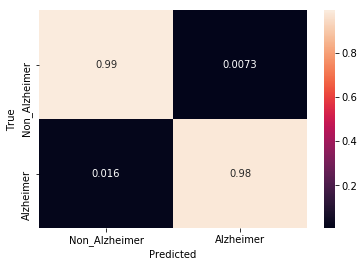

In [ ]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "Non_Alzheimer", "Alzheimer"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train["label"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

#Masked Word Prediction using BERT

In [ ]:
pip install -U pytorch-pretrained-bert

     |████████████████████████████████| 133kB 3.3MB/s 


In [ ]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpzav5dzrq
100%|██████████| 231508/231508 [00:00<00:00, 2670492.01B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpzav5dzrq to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpzav5dzrq
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f0006

In [ ]:
def getIndexPositions(listOfElements, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    indexPosList = []
    indexPos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            indexPos = listOfElements.index(element, indexPos)
            # Add the index position in list
            indexPosList.append(indexPos)
            indexPos += 1
        except ValueError as e:
            break
 
    return indexPosList

In [ ]:
#text = '[CLS] I want to [MASK] the car because it is cheap . [SEP]'
text = '[CLS] Alzheimer disease is caused by [MASK] [MASK]  [MASK]  [MASK]  [MASK] [MASK]  [MASK] . [SEP]'
#text = '[CLS] Alzheimer disease is caused by [MASK] [MASK]  [MASK]  [MASK]  [MASK]  [MASK]  [MASK] . [SEP]'
#text = '[CLS] Alzheimer disease is caused by [MASK] [MASK]  [MASK]  [MASK]  [MASK]  [MASK]  [MASK] . [SEP]'
#text = '[CLS] Thyrotropin-releasing hormone (TRH), luteinizing hormone-releasing [MASK] (LH-RH), substance P immuno-reactivity. [SEP]'
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Create the segments tensors.
segments_ids = [0] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)

# masked_index = tokenized_text.index('[MASK]')
# predicted_index = torch.argmax(predictions[0, masked_index]).item()
# predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

# print(predicted_token)

indexPosList = getIndexPositions(tokenized_text, '[MASK]')
for masked_index in indexPosList:
  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

  print(predicted_token)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp321rl3hc
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:pytorch_pretrained_bert.modeling:Weights from pretrained model not 

a
,
,
and
and
memory
disorder


In [ ]:
print(predictions.shape)

torch.Size([1, 19, 30522])


In [ ]:
# tokenized_text
# Get indexes of all occurrences of 'Ok' in the list
indexPosList = getIndexPositions(tokenized_text, '[MASK]')
indexPosList

[6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
for masked_index in indexPosList:
  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

  print(predicted_token)

a
,
,
,
,
##ly
or
or


In [ ]:
#Structural brain age is a valuable but complex biomarker for several brain disorders. The dog is an unrivalled comparator for neurological disease modeling, however canine brain morphometric diversity creates computational and statistical challenges. 
text = '[CLS] Structural brain age is a valuable but complex biomarker for several [MASK] disorders. The dog is an unrivalled comparator for neurological disease modeling, however canine brain morphometric diversity creates computational and statistical challenges.  [SEP]'
tokenized_text = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Create the segments tensors.
segments_ids = [0] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# Predict all tokens
with torch.no_grad():
    predictions = model(tokens_tensor, segments_tensors)
masked_index = tokenized_text.index('[MASK]')
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

print(predicted_token)

neurological


expected = brain

predicted = neurological

In [ ]:
#Structural brain age is a valuable but complex biomarker for several brain disorders. The dog is an unrivalled comparator for neurological disease modeling, however canine brain morphometric diversity creates computational and statistical challenges. 
def mask_prediction(text, mask):  
  #text = '[CLS] Structural brain age is a valuable but complex biomarker for several [MASK] disorders. The dog is an unrivalled comparator for neurological disease modeling, however canine brain morphometric diversity creates computational and statistical challenges.  [SEP]'
  tokenized_text = tokenizer.tokenize(text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  
  # Create the segments tensors.
  segments_ids = [0] * len(tokenized_text)
  
  # Convert inputs to PyTorch tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  # Load pre-trained model (weights)
  model = BertForMaskedLM.from_pretrained('bert-base-uncased')
  model.eval()
  
  # Predict all tokens
  with torch.no_grad():
      predictions = model(tokens_tensor, segments_tensors)
  masked_index = tokenized_text.index('[MASK]')
  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
  
  print(predicted_token + "\t"+ "expected: " + mask)
  
  return predicted_token==mask

In [ ]:
text = '[CLS] Structural brain age is a valuable but complex biomarker for several [MASK] disorders. The dog is an unrivalled comparator for neurological disease modeling, however canine brain morphometric diversity creates computational and statistical challenges.  [SEP]'
mask_prediction(text, "brain")

neurological	expected: brain


False

In [ ]:
mask_f = open("masked_test.txt", 'r', encoding='utf-8')
for lines  in mask_f:
  total_test_count=0
  pass_count = 0
  tok = lines.split("\t\t")
  if len(tok)==2:
    ans = mask_prediction(tok[0], tok[1].strip("\n"))
    if ans == True:
      pass_count += 1
    total_test_count +=1
pass_count/total_test_count
    
  

imaging	expected: imaging
compensated	expected: accounted
to	expected: to
these	expected: these
most	expected: most
who	expected: with
(	expected: (HR:
of	expected: of
data	expected: dataset
to	expected: to
two	expected: fifteen
the	expected: the
(	expected: (prodromal
to	expected: to
memory	expected: frPSI,
good	expected: better
and	expected: IL-12p40,
similar	expected: bilateral
of	expected: of
to	expected: to
vascular	expected: Alzheimers
blood	expected: cognitive
of	expected: of
containing	expected: with,
that	expected: accuracy
c	expected: GAS5
in	expected: in
plaques	expected: beta
increase	expected: increase
part	expected: component
in	expected: in
it	expected: AD


cardiovascular	expected: Alzheimers


RuntimeError: ignored